# Training a Classifier

## Imports and setup

First we'll set some options up to make everything display correctly. It's mostly because these assault descriptions can be quite long, and the default is to truncate text after a few words.

In [1]:
import pandas as pd

pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

%matplotlib inline

/Users/areena.arora/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Read in our data

Our dataset is going to be a database of crimes committed between 2008 and 2012. The data has been cleaned and filtered a bit, though, so we're only left with two columns:

* `CCDESC`, what criminal code was violated
* `DO_NARRATIVE`, a short text description of what happened

We're going to use this description to see if we can separate serious cases of assault compared to non-serious cases of assault.

In [2]:
X_train = pd.read_csv('assaults_downgraded_train.csv')
df = X_train
df

,Unnamed: 0,CCDESC,DO_NARRATIVE,serious,downgraded
0,823014,BATTERY - SIMPLE ASSAULT,DO-SUSP AND VICT INVOLVED IN ARGUMENT SUSP GRABBED VICT BY NECK PUSHED HERAGAINST WALL AND CHOKED HER,0,0
1,660053,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,DO-V1 AND V2 WERE DISCIPLINED BY STEPFATHER FRIDAY AFTER SCHOOL WITH A BELT V1 HAD SOME MINOR BRUSING ON BODY V2 HAD BRUISING ON HIS BODY,0,0
2,736013,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-UNK SUSPS DROVE UP ALONSIDE VICTS S YELLED FUCK 38 S1 THEN SHOT APPROX 4-5 RONDS FROM BLUE STEEL REVOLVER STRIKING V1 V2,1,0
3,255680,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-SUSP AND VICT BECAME INV IN A DISPUTE THAT ESCALATED WHEN THE SUSP HIT VICT ON HER LEFT ARM WITH A BAT,1,0
4,796623,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-VICT WALKED W B VENTRUA BLVD SUSPS DROVE PAST AND FIRED MULTIPLE BBS ATVICT VICT WERE STRUCK ONCE,1,0
...,...,...,...,...,...
165860,26664,BATTERY - SIMPLE ASSAULT,DO-SUSP AND VICT WERE INVOLVED IN A VERBAL ALTERCATION SUSP BECAME ANGRY STRUCK THE VICT LEAVING VISIBLE INJURY SUSP THEN FLED THE LOCATION,0,0
165861,450551,INTIMATE PARTNER - SIMPLE ASSAULT,DO-VICT AND SUSP BECAME INV IN VERBAL ARGUMENT SUSP BECAME ANGRY AND GRAB VICT HAIR THROWING VICT TO THE FLOOR,0,0
165862,758754,INTIMATE PARTNER - SIMPLE ASSAULT,DO-ON ABOVE DATE AND TIME S BECAME ANGRY AT V OVER AN ARGUEMENT S STRUCK VIN FACE WITH CLOSED FIST CAUSING BRUISES S FLED LOCATION,0,0
165863,273702,INTIMATE PARTNER - SIMPLE ASSAULT,DO-SUSP AND VICT ENGAGED IN VERBAL DISPUTE SUSP BECAME ANGRY STRUCK VICT MULTIPLE TIMES TO HER FACE AND ARMS CAUSING BRUISING VICT FLED LOC W CHILD,0,0


# Time to classify

Now we're going to build a classifier that can predict whether an assault is serious or non-serious. To do that, we first need to count all the words in each description.

## Stemming

When we talk about "words," we can mean a few different things. Do you feel like "stab," "stabbed," and "stabbing" should all count the same? If yes, you're interested in **stemming.**

Stemming is the process of trying to convert words to their root. There are a few different kinds of stemmers, but we'll be using one called **SnowballStemmer** that comes with NLTK.

In [4]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')

Let's see how it works in the case of different tenses of the word "stabbing:"

In [5]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')

print(stemmer.stem("stab"))
print(stemmer.stem("stabbed"))
print(stemmer.stem("stabbing"))

stab
stab
stab


Looks good! It also works with singular and plurals.

In [6]:
print(stemmer.stem("gun"))
print(stemmer.stem("guns"))

gun
gun


It can have trouble with more complicated words, though. Here's an example with "knife" as compared to "knives."

In [22]:
import nltk
# nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/areena.arora/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [23]:
print(stemmer.stem("knife"))
print(stemmer.stem("knifed"))
print(stemmer.stem("knives"))

# from nltk.stem import WordNetLemmatizer 
# lemmatizer = WordNetLemmatizer()
# print(lemmatizer.lemmatize('knife'))
# print(lemmatizer.lemmatize('knifed'))
# print(lemmatizer.lemmatize('knife'))

knife
knife
knive


If it gets most of what we're looking for, though, I think we're okay.

## Building a vectorizer that uses stemming

Vectorizing is the process of converting words to numbers, and counting each of them (along with any other transformations). It's a little complex to incorporate stemming into the process, but here we go.

We're also using a `TfidfVectorizer`, which doesn't count words exactly. More common words become less meaningful, and words in short sentences mean more than words in longer sentences.

For example, your name showing up in a tweet probably means the tweet is about you. If your name shows up once in a big, big book, though, the chances are much lower that the entire book is about you.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

stemmer = SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer,self).build_analyzer()
        return lambda doc:(stemmer.stem(word) for word in analyzer(doc))

Now we'll actually use our vectorizer to count the words. We're being a little picky, in that:

* We're only using words that show up at least 15 times in our dataset, and
* We're ignoring anything that shows up in more than half of the police reports

This helps cut down on noise. Adjusting the terms will give us a greater or fewer number of words, and might also affect our accuracy later on.

## Feature Engineering

Check out the documentation for TfIdfVectorizer and CountVectorizer
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

You can tweak the parameters in the code below and see how this vectorizer performs. For example, what happens when you modify `min_df` and `max_df`? What about adding some things to the `stop_words` list? Setting `binary` to True instead of False? 

Let's start with the default and you can come back to modify some things later!

In [25]:
%%time

# Check out the documentation for TfIdfVectorizer and CountVectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vectorizer = StemmedTfidfVectorizer(min_df=0.1, max_df=0.5)

X = vectorizer.fit_transform(df.DO_NARRATIVE)
X

CPU times: user 32.4 s, sys: 136 ms, total: 32.5 s
Wall time: 32.6 s


<165865x27 sparse matrix of type '<class 'numpy.float64'>'
	with 770117 stored elements in Compressed Sparse Row format>

If we're only paying attention to words that show up at least 15 times, and are ignoring words that show up in half of the reports, how many words we we using?

In [26]:
len(vectorizer.get_feature_names())

/Users/areena.arora/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


27

While it doesn't do us much good in terms of analysis, we can take a pick look at our words and sentences to see what shows up where.

In [27]:
words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
words_df.head(10)

,argument,at,becam,caus,disput,face,fled,grab,her,hit,injuri,involv,loc,of,on,punch,push,struck,the,then,time,to,unk,verbal,was,were,with
0,0.415483,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.483761,0.424230,0.000000,0.0,0.464014,0.0,0.0,0.000000,0.0,0.44505,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.752430,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.541044,0.375660
2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.707824,0.00000,0.000000,0.706389,0.0,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.387224,0.0,0.432059,0.0,0.000000,0.000000,0.411951,0.436801,0.0,0.000000,0.0,0.0,0.329389,0.0,0.00000,0.000000,0.293612,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.328904
4,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.664020,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.747715,0.000000
5,0.602614,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.491984,0.0,0.00000,0.628338,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.400505,0.559061,0.396739,0.41484,0.000000,0.000000,0.0,0.444468,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.624876,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.581099,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.521396,0.000000,0.0,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.458274,0.000000,0.000000,0.565139,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.538070,0.0,0.000000,0.000000,0.425540
9,0.000000,0.514382,0.000000,0.0,0.539409,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.525203,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.410623


## Classify

> "SVM models perform better on sparse data than does trees in general. For example in document classification you may have thousands, even tens of thousands of features and in any given document vector only a small fraction of these features may have a value greater than zero."
>
> https://towardsdatascience.com/support-vector-machine-vs-logistic-regression-94cc2975433f

In [28]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

In [29]:
%%time

X = words_df
y = df.serious

clf = LinearSVC()
clf.fit(X, y)

CPU times: user 1.02 s, sys: 12.9 ms, total: 1.04 s
Wall time: 1.04 s


LinearSVC()

Here is how accurate the classifier is! What does that mean????

# Evaluate the classifier

In [30]:
# Remember, this gives you the accuracy
cross_val_score(clf, X, y)

array([0.79061285, 0.78988937, 0.7875682 , 0.79302445, 0.79190908])

In [31]:
from sklearn.model_selection import cross_validate

scores = cross_validate(clf, X, y, cv=10,
                        scoring=('accuracy', 'precision', 'recall', 'f1'))

# here are some other types of scores
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

scores_df = pd.DataFrame(scores)

display(scores_df.round(2))

pd.DataFrame(scores)[
    ['fit_time', 'score_time', 'test_accuracy','test_precision','test_recall','test_f1']]\
    .mean().round(2)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,0.91,0.02,0.79,0.65,0.28,0.39
1,0.88,0.02,0.79,0.66,0.29,0.40
2,0.87,0.01,0.79,0.65,0.29,0.40
3,0.88,0.01,0.79,0.65,0.28,0.39
4,0.89,0.02,0.79,0.64,0.29,0.40
5,0.90,0.02,0.79,0.64,0.27,0.38
6,0.92,0.01,0.80,0.67,0.30,0.42
7,0.89,0.03,0.79,0.65,0.29,0.40
8,0.90,0.01,0.79,0.66,0.29,0.40
9,0.94,0.01,0.79,0.65,0.29,0.40


fit_time          0.90
score_time        0.02
test_accuracy     0.79
test_precision    0.65
test_recall       0.29
test_f1           0.40
dtype: float64

## Peeking inside the classifier
### Which words are most important?

Before we see how our classifier performs, let's take a look at which words point towards a report being either simple or aggravated assault. In this case, we're going to look at the top and bottom 20 terms.

In [33]:
import eli5

eli5.show_weights(clf, vec=vectorizer, top=(20, 20))

/Users/areena.arora/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


If we jump through a couple hoops, we can also have a nice colored graphic!

<AxesSubplot:ylabel='feature'>

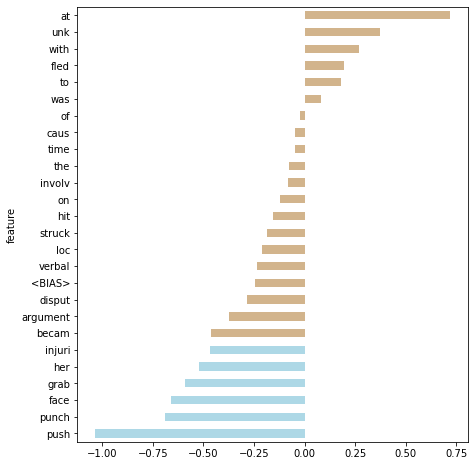

In [34]:
# Build a dataframe of what we have above
weights = eli5.explain_weights_df(clf, vec=vectorizer, top=(20, 20))

# Pick colors based on being above or below zero
colors = weights.weight.apply(lambda weight: 'lightblue' if weight > 0 else 'tan')

# Sort it and plot it
weights.sort_values(
    by='weight',
    ascending=True
).plot(
    y='weight',
    x='feature',
    kind='barh',
    figsize=(7,8),
    color=colors,
    legend=False
)


Outputting coefficients to a CSV file

In [35]:
coefs = pd.DataFrame(clf.coef_, columns = clf.feature_names_in_ ).T.rename(columns = {0:'coef_'})
coefs.to_csv('coefs.csv')
coefs.sort_values(by='coef_')

,coef_
push,-1.036625
punch,-0.689797
face,-0.659415
grab,-0.593043
her,-0.523066
injuri,-0.469277
becam,-0.461513
argument,-0.375641
disput,-0.284211
verbal,-0.235138


# Discussion

Did the machine learn the same rules you did? 

* Does it sound reasonable which terms imply aggravated vs simple assault?
* Which ones are misspellings? Does that worry you?
* Are there any terms in there you don't quite get?

There's another notebook - "Inspecting misclassifications" - that goes a bit deeper into these terms and what they may (or may not) mean.

https://investigate.ai/latimes-crime-classification/inspecting-classifications/
